# **1. 라이브러리 import**

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact

# **2. Data Descrpition**

In [ ]:
'''
DataSet
ㄴ train
  ㄴ angry
  ㄴ disgust
  ㄴ fear
  ㄴ happy
  ㄴ neutral
  ㄴ sad
  ㄴ surprise
ㄴ valid
  ㄴ angry
  ㄴ disgust
  ㄴ fear
  ㄴ happy
  ㄴ neutral
  ㄴ sad
  ㄴ surprise
ㄴ test
  ㄴ angry
  ㄴ disgust
  ㄴ fear
  ㄴ happy
  ㄴ neutral
  ㄴ sad
  ㄴ surprise
'''
print()

- train, test dataset으로 이미 분리가 되어있는 상태
- train data : test data가 4:1 정도 -> 둘을 합친 후 다시 8:2 비율로 나누어준다.
- 각각의 데이터는 다시 7개의 감정(angry, disgust, fear, happy, neutral, sad, surprise)으로 분류
- 현재 데이터 셋에서 폴더는 정렬되어 있지만, 사진명은 정렬이 되어 있지 않다.
> 사진명의 형식을 모두 통일시켜 이후의 데이터 처리 작업을 원할하게 진행하고자 한다.

- 각 사진의 크기는 48 * 48 size 흑백 사진
- 사람 얼굴이 아닌 것들도 포함되어 있음(캐릭터 등) -> 삭제

### **2-1.Train/Test 재분배**
- train:val:test = 8:1:1로 분할 후, 각각의 폴더에 저장

In [2]:
dataset_path = "C:\\waterbean\\Personal_proj\\FacialExpression\\DataSet\\archive"

In [3]:
# 필요한 모듈 import
import os
import shutil

from glob import glob
from sklearn.model_selection import train_test_split

- 아래의 코드는 최초 1번만 시행한다.(이후 시행 시 에러)

In [ ]:
# 전체 데이터셋은 각 감정별로 7개의 폴더로 구성됨
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# 각 폴더에 접근하여 train/valid/test로 split
for feeling in feelings_list:
    feeling_path = dataset_path + '\\'+feeling
    # 이미지 목록 받기
    image_files = glob(feeling_path+'\\*')
    
    images = [name.replace(".jpg","") for name in image_files]
    
    # 이미지 분할
    # train:val:test = 8:1:1
    train_names,test_names = train_test_split(images,test_size = 0.2,random_state = 42,shuffle = True)
    val_names,test_names = train_test_split(test_names,test_size = 0.5,random_state = 42,shuffle = True)
    
    
    def batch_move_files(file_list,source_path,destination_path):
        for file in file_list:
            # 경로에서 마지막 파일명만 가져와서 확장자 붙여주기
            image = file.split('\\')[-1] + '.jpg'
            shutil.copy(os.path.join(source_path,image),destination_path)
        return
    
    # 경로 설정하기
    source_dir = feeling_path
    
    train_dir = dataset_path + "\\train" +'\\'+feeling
    val_dir = dataset_path + "\\valid" +'\\'+feeling
    test_dir = dataset_path + "\\test" +'\\'+feeling
    
    batch_move_files(train_names,source_dir,train_dir)
    batch_move_files(val_names,source_dir,val_dir)
    batch_move_files(test_names,source_dir,test_dir)

### **2-2. 이름 재정의하기**

In [4]:
### train, test에 따라 경로에 접근

purposes_list = ['test', 'train', 'valid']
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

- 해당 코드를 여러 번 수행 시 파일명이 변경되어 파일 계층 구조가 바뀔 수 있으므로 최초 1회만 시행한다.

In [ ]:
dataset_path = "C:\\waterbean\\Personal_proj\\FacialExpression\\DataSet\\archive" 
# 폴더 이름에 따라 파일이름을 바꿀 것이므로 그 상위 폴더인 Archive을 path로 설정

for purpose in purposes_list :                                                    
    ### 각 목적 폴더 경로 생성
    purpose_path = dataset_path + "\\" + purpose                                    
    # 예시> purpose_path = C:\\waterbean\\Personal_proj\\FacialExpression\\DataSet\\archive\\test
    
    for feeling in feelings_list:
        ### 7개의 감정이 분류된 폴더 경로 설정
        
        feeling_path = purpose_path + "\\" + feeling
        # 예시> feeling_path = C:\\waterbean\\Personal_proj\\FacialExpression\\DataSet\\archive\\test\\angry
        file_list = os.listdir(feeling_path)
        # file_list[0] = 폴더 경로 + 이미지명.jpg
        
        print("-------------------------------------------------")
        print(feeling + " have " + str(len(file_list)) + " files.")
        print("feeling_path : " + feeling_path)
        
        ### 이미 이름이 있는 파일이면 오류가 나기에, 먼저 숫자로 된 아무 이름 짓기
        count = 1
        for file_name in file_list :
            old_name = feeling_path + "\\" + file_name                                     
            new_name = feeling_path + "\\" + str(count) + ".jpg"                           
            # new_name = C:\\waterbean\\Personal_proj\\FacialExpression\\DataSet\\archive\\test\\angry\\1.jpg
            
            try:
                os.rename(old_name, new_name)
                print("success : " + old_name + " -> " + new_name)
            except:
                print("fail : " + old_name + " -> " + new_name)
                print("이미 존재하는 파일명입니다.")
            count = count + 1
        
        ### 원하는 형식으로 이름 다시 지정
        
        file_list = os.listdir(feeling_path)                                               
        
        # 1.jpg 로 바뀐 이름을 가져와야 되기 때문에 다시 로드
        count = 1
        for file_name in file_list :
            old_name = feeling_path + "\\" + file_name  # old_name = 1.jpg
            new_name = feeling_path + "\\" + feeling + "_" + str(count) + ".jpg"  # new_name = angry_1.jpg

            try:
                os.rename(old_name, new_name)
                print("success : " + old_name + " -> " + new_name)
            except:
                print("fail : " + old_name + " -> " + new_name)
                print("이미 존재하는 파일명입니다.")
                break
            count = count + 1

# **3. 이미지 파일 경로 불러오기**

In [5]:
### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수

def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [6]:
data_dir = './DataSet/archive/train' # 상위 폴더 경로

angry_list = list_image_file(data_dir,'angry')
disgust_list = list_image_file(data_dir,'disgust')
fear_list = list_image_file(data_dir,'fear')
happy_list = list_image_file(data_dir,'happy')
neutral_list = list_image_file(data_dir,'neutral')
sad_list = list_image_file(data_dir,'sad')
surprise_list = list_image_file(data_dir,'surprise')

In [7]:
### 데이터 경로가 잘 저장되었는지 확인

print(angry_list[0])
print(disgust_list[0])
print(fear_list[0])
print(happy_list[0])
print(neutral_list[0])
print(sad_list[0])
print(surprise_list[0])

angry\angry_1.jpg
disgust\disgust_1.jpg
fear\fear_1.jpg
happy\happy_1.jpg
neutral\neutral_1.jpg
sad\sad_1.jpg
surprise\surprise_1.jpg


# **4. 이미지 데이터 시각화**

In [8]:
### 이미지 파일을 RGB 3차원 배열로 가져오는 함수

def get_RGB_image(data_dir,file_name):
    image_file = os.path.join(data_dir,file_name) # 이미지 경로 설정
    image = cv2.imread(image_file) # 이미지 열기
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # BGR -> RGB
    
    return image

In [9]:
### 데이터의 분포 확인

print('angry 이미지 개수: {}'.format(len(angry_list)))
print('disgust 이미지 개수: {}'.format(len(disgust_list)))
print('fear 이미지 개수: {}'.format(len(fear_list)))
print('happy 이미지 개수: {}'.format(len(happy_list)))
print('neutral 이미지 개수: {}'.format(len(neutral_list)))
print('sad 이미지 개수: {}'.format(len(sad_list)))
print('surprise 이미지 개수: {}'.format(len(surprise_list)))

angry 이미지 개수: 3962
disgust 이미지 개수: 875
fear 이미지 개수: 4096
happy 이미지 개수: 7191
neutral 이미지 개수: 4958
sad 이미지 개수: 4861
surprise 이미지 개수: 3201


In [16]:
### 이미지 데이터 시각화

min_num_files = 875 # disgust 데이터의 개수

@interact(index = (0,min_num_files - 1)) # index를 변경해가며 사진 확인
def show_sample(index = 0):
    angry_image = get_RGB_image(data_dir,angry_list[index])
    disgust_image = get_RGB_image(data_dir,disgust_list[index])
    fear_image = get_RGB_image(data_dir,fear_list[index])
    happy_image = get_RGB_image(data_dir,happy_list[index])
    neutral_image = get_RGB_image(data_dir,neutral_list[index])
    sad_image = get_RGB_image(data_dir,sad_list[index])
    surprise_image = get_RGB_image(data_dir,surprise_list[index])
    
    plt.figure(figsize = (12,12))
    plt.subplot(241)
    plt.title('angry')
    plt.imshow(angry_image)
    
    plt.subplot(242)
    plt.title('disgust')
    plt.imshow(disgust_image)
    
    plt.subplot(243)
    plt.title('fear')
    plt.imshow(fear_image)
    
    plt.subplot(244)
    plt.title('happy')
    plt.imshow(happy_image)
    
    plt.subplot(245)
    plt.title('neutral')
    plt.imshow(neutral_image)
    
    plt.subplot(246)
    plt.title('sad')
    plt.imshow(sad_image)
    
    plt.subplot(247)
    plt.title('surprise')
    plt.imshow(surprise_image)
    
    plt.tight_layout(h_pad=-1)

interactive(children=(IntSlider(value=0, description='index', max=874), Output()), _dom_classes=('widget-inter…

# **5. DataFrame 형태로 정렬**

In [17]:
feeling_images = [] #감정이 labeling 된 data 전체가 담길 빈 리스트

### 각 이미지 파일에 대해 감정을 labeling하는 함수
def put_label(feeling,emotion):
    for i in range(len(feeling)):
        file = str(feeling[i]).split('\\')[-1]
        feeling_images.append([file,str(emotion)])  # 매개변수로 넘어오는 감정을 label로 같이 저장

In [18]:
put_label(angry_list,'angry')
put_label(disgust_list,'disgust')
put_label(fear_list,'fear')
put_label(happy_list,'happy')
put_label(neutral_list,'neutral')
put_label(sad_list,'sad')
put_label(surprise_list,'surprise')

In [19]:
### Dataframe 생성
colnames = ['file','emotion']  

feelings_df= pd.DataFrame(feeling_images,columns = colnames)
feelings_df

,file,emotion
0,angry_1.jpg,angry
1,angry_10.jpg,angry
2,angry_100.jpg,angry
3,angry_1000.jpg,angry
4,angry_1001.jpg,angry
...,...,...
29139,surprise_995.jpg,surprise
29140,surprise_996.jpg,surprise
29141,surprise_997.jpg,surprise
29142,surprise_998.jpg,surprise


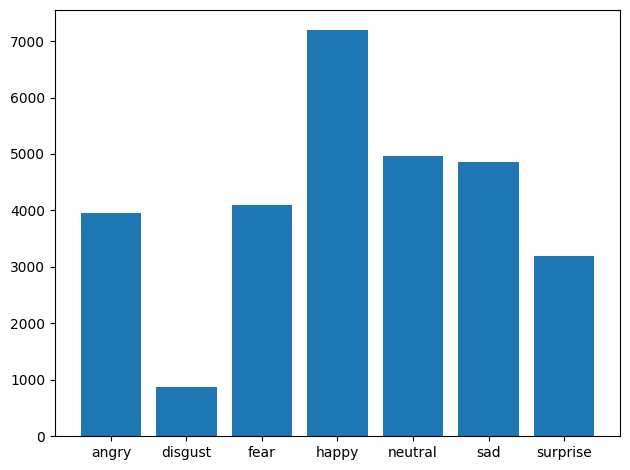

In [20]:
value_counts = feelings_df['emotion'].value_counts().sort_index()

plt.bar(range(len(value_counts)),value_counts.values,align = "center")
plt.xticks(range(len(value_counts)),value_counts.index.values)

plt.tight_layout()
plt.show()

- disgust의 경우 다른 감정들의 데이터에 비해 개수가 현저히 적다.
> 불균형한 데이터이다.
- 불균형한 데이터에 대한 처리가 필요하다.

In [21]:
### csv 파일 형태로 저장

# 이후 모델 학습 시 데이터를 편리하게 가져오기 위함
# 앞에 붙여진 index를 날리고 저장

feelings_df.to_csv('train.csv',index = False)